## Notebook for data analysis of 'interneuron' sessions [mostly local photostimulation of random groups while imaging interneuron + excitatory responses]

In [3]:
%run ./rob_setup_notebook.ipynb

import utils.interareal_analysis as ia
import utils.interareal_plotting as ip
import utils.utils_funcs as uf
import utils.gsheets_importer as gsi
import ia_funcs as ia 
from utils.paq2py import *

session_type = 'interneuron'


Suite2p path: ['/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/suite2p']
QNAP_path: /home/rlees/mnt/qnap 
QNAP_data_path /home/rlees/mnt/qnap/Data 
Pickle folder: /home/rlees/mnt/qnap/pkl_files 
Master pickle: /home/rlees/mnt/qnap/master_pkl/master_obj.pkl 
Figure save path: /home/rlees/mnt/qnap/Analysis/Figures 
STA movie save path: /home/rlees/mnt/qnap/Analysis/STA_movies 
S2 borders path: /home/rlees/mnt/qnap/Analysis/S2_borders


In [19]:
pkl_files = ia.listdirFullpath(pkl_folder + '/interneuron', '20_RL124.pkl')

session_ids = [pkl.split('/')[-1][:-4] for pkl in pkl_files]

for pkl, session_id in zip(pkl_files, session_ids):
    
    ses_obj = ia.loadPickle(pkl)

Loading pickle: /home/rlees/mnt/qnap/pkl_files/interneuron/2021-01-20_RL124.pkl


2021-01-20_RL124
number of interneurons: 46
searching for interneuron cell ids...
search completed.
Number of interneuron cells:  15


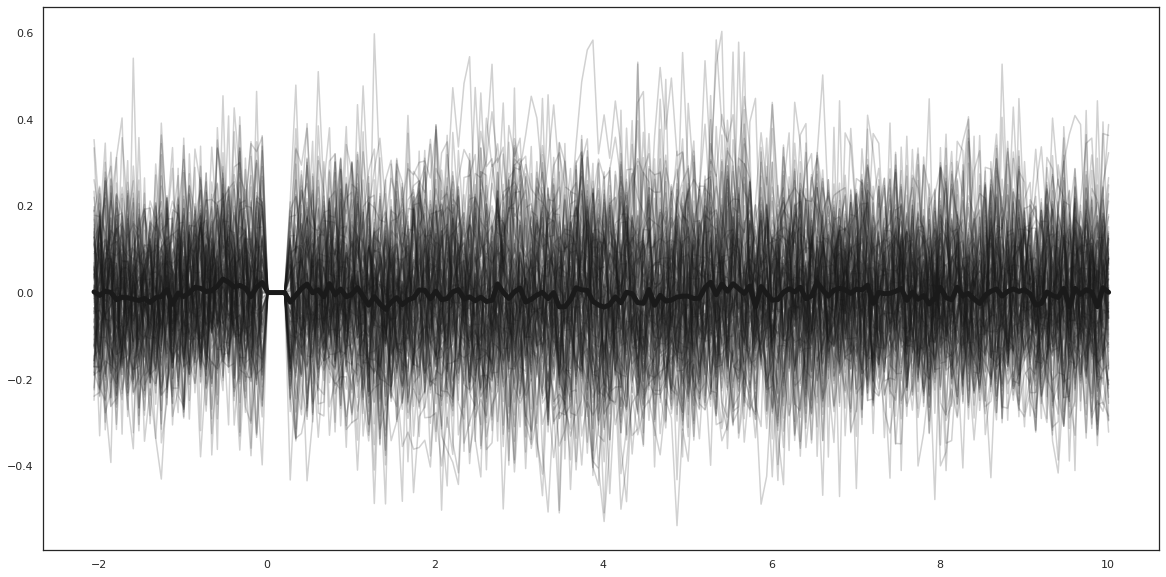

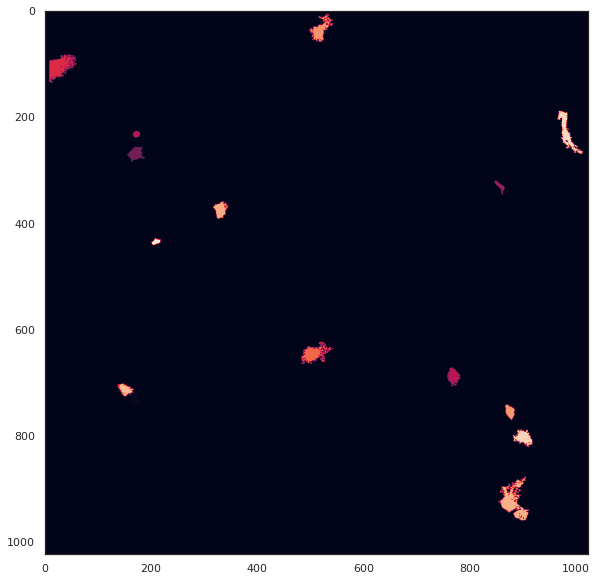

In [20]:
# manually pick out tdtomato cells in imagej
# load in points from imagej to python (maybe using target approach?)
# use points to assign new information to cells in the exp_objs, i.e. 'interneuron_id' = True/False
# plot activity of interneurons vs excitatory neurons on photostim and spont trials (all or subset?)
# add this metric to dataframe creation

exp_obj = ses_obj.spont
print(exp_obj.sheet_name)

interneuron_points = ia.listdirFullpath(ses_obj.photostim_r.tiff_path, 'interneuron')
interneuron_img = tf.imread(interneuron_points)

interneuron_coords = np.where(interneuron_img>0)
interneuron_coords = list(zip(interneuron_coords[0], interneuron_coords[1]))
n_interneurons = len(interneuron_coords)

print('number of interneurons:', n_interneurons)

print('searching for interneuron cell ids...')

# make an image of every cell area, filled with the index of that cell
cell_img = np.zeros_like(interneuron_img)

cell_x = np.array(exp_obj.cell_x)
cell_y = np.array(exp_obj.cell_y)

for i,coord in enumerate(zip(cell_x[0], cell_y[0])):
    cell_img[coord] = i+1

# binary mask x cell image to get the cells that overlap with target areas
interneuron_cells = cell_img*interneuron_img

interneuron_cell_ids = np.unique(interneuron_cells)[1:]-1 # correct the cell id due to zero indexing
exp_obj.interneurons = np.zeros([exp_obj.n_units[0]], dtype='bool')
exp_obj.interneurons[interneuron_cell_ids] = True 

exp_obj.n_interneurons = np.sum(exp_obj.interneurons)

print('search completed.')
print('Number of interneuron cells: ', exp_obj.n_interneurons)

interneuron_trials = exp_obj.all_trials[0][exp_obj.interneurons]

plt.figure(figsize=(20,10))
plt.plot(exp_obj.time, np.mean(interneuron_trials, axis=(0)), 'k', alpha=0.2)
plt.plot(exp_obj.time, np.mean(interneuron_trials, axis=(0,2)), 'k', lw=5)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(ia.s2pMasks(exp_obj.s2p_path, np.where(exp_obj.interneurons)[0]));

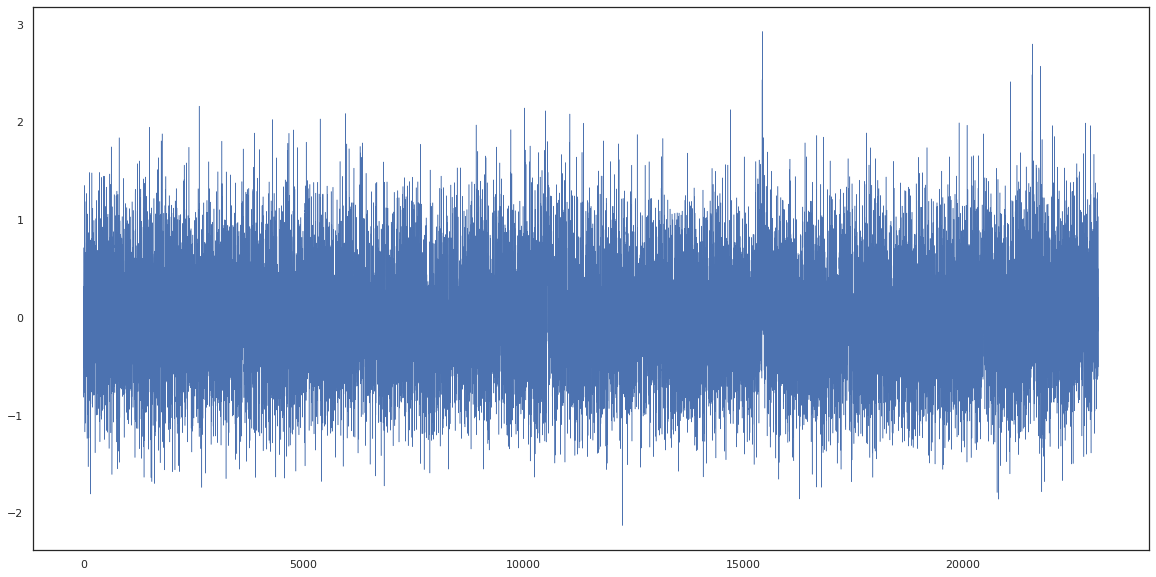

In [86]:
int_traces = exp_obj.dfof[0][exp_obj.interneurons][12]
plt.figure(figsize=(20,10))
plt.plot(int_traces.T, lw=0.5)
# plt.xlim([11000,12000]);
# plt.ylim([-1,5]);